# Logistic Regression with L2 regularization

The goal of this second notebook is to implement your own logistic regression classifier with L2 regularization. You will do the following:

 * Extract features from Amazon product reviews.
 * Convert an DataFrame into a NumPy array.
 * Write a function to compute the derivative of log likelihood function with an L2 penalty with respect to a single coefficient.
 * Implement gradient ascent with an L2 penalty.
 * Empirically explore how the L2 penalty can ameliorate overfitting.
 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Load and process review dataset

For this assignment, we will use the same subset of the Amazon product review dataset that we used in Module 3 assignment. The subset was chosen to contain similar numbers of positive and negative reviews, as the original dataset consisted of mostly positive reviews.

In [2]:
products = pd.read_csv('amazon_baby.csv')
products = products[:35000]

In [3]:
products[:10]

,name,review,rating
0,Planetwise Flannel Wipes,"These flannel wipes are OK, but in my opinion ...",3
1,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5
2,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5
3,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,5
4,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5
5,Stop Pacifier Sucking without tears with Thumb...,"When the Binky Fairy came to our house, we did...",5
6,A Tale of Baby\'s Days with Peter Rabbit,"Lovely book, it\'s bound tightly so you may no...",4
7,"Baby Tracker&reg; - Daily Childcare Journal, S...",Perfect for new parents. We were able to keep ...,5
8,"Baby Tracker&reg; - Daily Childcare Journal, S...",A friend of mine pinned this product on Pinter...,5
9,"Baby Tracker&reg; - Daily Childcare Journal, S...",This has been an easy way for my nanny to reco...,4


Just like we did previously, we will work with a hand-curated list of important words extracted from the review data. We will also perform 2 simple data transformations:

1. Remove punctuation using [Python's built-in](https://docs.python.org/2/library/string.html) string functionality.
2. Compute word counts (only for the **important_words**)

Refer to Module 3 assignment for more details.

In [4]:
# The same feature processing (same as the previous assignments)
# ---------------------------------------------------------------
import json
with open('important_words.json', 'r') as f: # Reads the list of most frequent words
    important_words = json.load(f)
important_words = [str(s) for s in important_words]
print(important_words)

['baby', 'one', 'great', 'love', 'use', 'would', 'like', 'easy', 'little', 'seat', 'old', 'well', 'get', 'also', 'really', 'son', 'time', 'bought', 'product', 'good', 'daughter', 'much', 'loves', 'stroller', 'put', 'months', 'car', 'still', 'back', 'used', 'recommend', 'first', 'even', 'perfect', 'nice', 'bag', 'two', 'using', 'got', 'fit', 'around', 'diaper', 'enough', 'month', 'price', 'go', 'could', 'soft', 'since', 'buy', 'room', 'works', 'made', 'child', 'keep', 'size', 'small', 'need', 'year', 'big', 'make', 'take', 'easily', 'think', 'crib', 'clean', 'way', 'quality', 'thing', 'better', 'without', 'set', 'new', 'every', 'cute', 'best', 'bottles', 'work', 'purchased', 'right', 'lot', 'side', 'happy', 'comfortable', 'toy', 'able', 'kids', 'bit', 'night', 'long', 'fits', 'see', 'us', 'another', 'play', 'day', 'money', 'monitor', 'tried', 'thought', 'never', 'item', 'hard', 'plastic', 'however', 'disappointed', 'reviews', 'something', 'going', 'pump', 'bottle', 'cup', 'waste', 'retu

In [5]:
# remove punctuations and clean words
def remove_punctuation(text):
    import string
    return str(text).translate(string.punctuation) 


In [6]:
# Remove punctuation.
products['review_clean'] = products['review'].apply(remove_punctuation)

# Split out the words into individual columns
for word in important_words:
    products[word] = products['review_clean'].apply(lambda s : s.split().count(word))

Now, let us take a look at what the dataset looks like (**Note:** This may take a few minutes).

In [7]:
products['sentiment'] = products['rating'].apply(lambda x: +1 if x>3 else -1)
products

,name,review,rating,review_clean,baby,one,great,love,use,would,...,picture,completely,wish,buying,babies,won,tub,almost,either,sentiment
0,Planetwise Flannel Wipes,"These flannel wipes are OK, but in my opinion ...",3,"These flannel wipes are OK, but in my opinion ...",0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,-1
1,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5,it came early and was not disappointed. i love...,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5,Very soft and comfortable and warmer than it l...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,5,This is a product well worth the purchase. I ...,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,1
4,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,All of my kids have cried non-stop when I trie...,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,Stop Pacifier Sucking without tears with Thumb...,"When the Binky Fairy came to our house, we did...",5,"When the Binky Fairy came to our house, we did...",0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,1
6,A Tale of Baby\'s Days with Peter Rabbit,"Lovely book, it\'s bound tightly so you may no...",4,"Lovely book, it\'s bound tightly so you may no...",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7,"Baby Tracker&reg; - Daily Childcare Journal, S...",Perfect for new parents. We were able to keep ...,5,Perfect for new parents. We were able to keep ...,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
8,"Baby Tracker&reg; - Daily Childcare Journal, S...",A friend of mine pinned this product on Pinter...,5,A friend of mine pinned this product on Pinter...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9,"Baby Tracker&reg; - Daily Childcare Journal, S...",This has been an easy way for my nanny to reco...,4,This has been an easy way for my nanny to reco...,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


## Train-Validation split

We split the data into a train-validation split with 80% of the data in the training set and 20% of the data in the validation set. We use `seed=2` so that everyone gets the same result.

**Note:** In previous assignments, we have called this a **train-test split**. However, the portion of data that we don't train on will be used to help **select model parameters**. Thus, this portion of data should be called a **validation set**. Recall that examining performance of various potential models (i.e. models with different parameters) should be on a validation set, while evaluation of selected model should always be on a test set.

In [8]:
from sklearn.model_selection import train_test_split

x_train , x_validation, y_train, y_validation = train_test_split(products,products['sentiment'], test_size =.2, random_state=20)

print ('Training set   : %d data points' % len(x_train) )
print ('Validation set : %d data points' % len(x_validation) )

Training set   : 28000 data points
Validation set : 7000 data points


## Convert SFrame to NumPy array

Just like in the second assignment of the previous module, we provide you with a function that extracts columns from an SFrame and converts them into a NumPy array. Two arrays are returned: one representing features and another representing class labels. 

**Note:** The feature matrix includes an additional column 'intercept' filled with 1's to take account of the intercept term.

In [9]:
import numpy as np

def get_numpy_data(data_frame, features, label):
    data_frame['intercept'] = 1
    features = ['intercept'] + features
    feature_matrix = data_frame[features]
    label_array = data_frame[label]
    return(feature_matrix, label_array)

We convert both the training and validation sets into NumPy arrays.

**Warning**: This may take a few minutes.

In [10]:
feature_matrix_train, sentiment_train = get_numpy_data(x_train, important_words, 'sentiment')
feature_matrix_valid, sentiment_valid = get_numpy_data(x_validation, important_words, 'sentiment') 

C:\Users\Srikanth\AppData\Local\conda\conda\envs\SRI\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


**Are you running this notebook on an Amazon EC2 t2.micro instance?** (If you are using your own machine, please skip this section)

It has been reported that t2.micro instances do not provide sufficient power to complete the conversion in acceptable amount of time. For interest of time, please refrain from running `get_numpy_data` function. Instead, download the [binary file](https://s3.amazonaws.com/static.dato.com/files/coursera/course-3/numpy-arrays/module-4-assignment-numpy-arrays.npz) containing the four NumPy arrays you'll need for the assignment. To load the arrays, run the following commands:
```
arrays = np.load('module-4-assignment-numpy-arrays.npz')
feature_matrix_train, sentiment_train = arrays['feature_matrix_train'], arrays['sentiment_train']
feature_matrix_valid, sentiment_valid = arrays['feature_matrix_valid'], arrays['sentiment_valid']
```

## Building on logistic regression with no L2 penalty assignment

Let us now build on Module 3 assignment. Recall from lecture that the link function for logistic regression can be defined as:

$$
P(y_i = +1 | \mathbf{x}_i,\mathbf{w}) = \frac{1}{1 + \exp(-\mathbf{w}^T h(\mathbf{x}_i))},
$$

where the feature vector $h(\mathbf{x}_i)$ is given by the word counts of **important_words** in the review $\mathbf{x}_i$. 

We will use the **same code** as in this past assignment to make probability predictions since this part is not affected by the L2 penalty.  (Only the way in which the coefficients are learned is affected by the addition of a regularization term.)

In [11]:
'''
produces probablistic estimate for P(y_i = +1 | x_i, w).
estimate ranges between 0 and 1.
'''
def predict_probability(feature_matrix, coefficients):
    # Take dot product of feature_matrix and coefficients  
    ## YOUR CODE HERE
    score=np.dot(feature_matrix,coefficients)
    
    # Compute P(y_i = +1 | x_i, w) using the link function
    ## YOUR CODE HERE
    predictions = 1/(1+np.exp(-score))
    
    return predictions

# Adding  L2 penalty

Let us now work on extending logistic regression with L2 regularization. As discussed in the lectures, the L2 regularization is particularly useful in preventing overfitting. In this assignment, we will explore L2 regularization in detail.

Recall from lecture and the previous assignment that for logistic regression without an L2 penalty, the derivative of the log likelihood function is:
$$
\frac{\partial\ell}{\partial w_j} = \sum_{i=1}^N h_j(\mathbf{x}_i)\left(\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w})\right)
$$

** Adding L2 penalty to the derivative** 

It takes only a small modification to add a L2 penalty. All terms indicated in **red** refer to terms that were added due to an **L2 penalty**.

* Recall from the lecture that the link function is still the sigmoid:
$$
P(y_i = +1 | \mathbf{x}_i,\mathbf{w}) = \frac{1}{1 + \exp(-\mathbf{w}^T h(\mathbf{x}_i))},
$$
* We add the L2 penalty term to the per-coefficient derivative of log likelihood:
$$
\frac{\partial\ell}{\partial w_j} = \sum_{i=1}^N h_j(\mathbf{x}_i)\left(\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w})\right) \color{red}{-2\lambda w_j }
$$

The **per-coefficient derivative for logistic regression with an L2 penalty** is as follows:
$$
\frac{\partial\ell}{\partial w_j} = \sum_{i=1}^N h_j(\mathbf{x}_i)\left(\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w})\right) \color{red}{-2\lambda w_j }
$$
and for the intercept term, we have
$$
\frac{\partial\ell}{\partial w_0} = \sum_{i=1}^N h_0(\mathbf{x}_i)\left(\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w})\right)
$$

**Note**: As we did in the Regression course, we do not apply the L2 penalty on the intercept. A large intercept does not necessarily indicate overfitting because the intercept is not associated with any particular feature.

Write a function that computes the derivative of log likelihood with respect to a single coefficient $w_j$. Unlike its counterpart in the last assignment, the function accepts five arguments:
 * `errors` vector containing $(\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w}))$ for all $i$
 * `feature` vector containing $h_j(\mathbf{x}_i)$  for all $i$
 * `coefficient` containing the current value of coefficient $w_j$.
 * `l2_penalty` representing the L2 penalty constant $\lambda$
 * `feature_is_constant` telling whether the $j$-th feature is constant or not.

In [10]:
def feature_derivative_with_L2(errors, feature, coefficient, l2_penalty, feature_is_constant): 
    
    # Compute the dot product of errors and feature
    ## YOUR CODE HERE
    derivative = np.dot(errors, feature)

    # add L2 penalty term for any feature that isn't the intercept.
    if not feature_is_constant: 
        ## YOUR CODE HERE
        derivative -= 2*l2_penalty*coefficient
        
    return derivative

** Quiz Question:** In the code above, was the intercept term regularized?

To verify the correctness of the gradient ascent algorithm, we provide a function for computing log likelihood (which we recall from the last assignment was a topic detailed in an advanced optional video, and used here for its numerical stability).

$$\ell\ell(\mathbf{w}) = \sum_{i=1}^N \Big( (\mathbf{1}[y_i = +1] - 1)\mathbf{w}^T h(\mathbf{x}_i) - \ln\left(1 + \exp(-\mathbf{w}^T h(\mathbf{x}_i))\right) \Big) \color{red}{-\lambda\|\mathbf{w}\|_2^2} $$

In [11]:
def compute_log_likelihood_with_L2(feature_matrix, sentiment, coefficients, l2_penalty):
    indicator = (sentiment==+1)
    scores = np.dot(feature_matrix, coefficients)
    logex = np.log(1. + np.exp(-scores))
    lp = np.sum((indicator-1)*scores - logex) - l2_penalty*np.sum(coefficients**2)
    
    return lp

** Quiz Question:** Does the term with L2 regularization increase or decrease $\ell\ell(\mathbf{w})$?

The logistic regression function looks almost like the one in the last assignment, with a minor modification to account for the L2 penalty.  Fill in the code below to complete this modification.

In [12]:
def logistic_regression_with_L2(feature_matrix, sentiment, initial_coefficients, step_size, l2_penalty, max_iter):
    coefficients = np.array(initial_coefficients) # make sure it's a numpy array
    
    for itr in range(max_iter):
        # Predict P(y_i = +1|x_i,w) using your predict_probability() function
        ## YOUR CODE HERE
        predictions = predict_probability(feature_matrix, coefficients)
        
        # Compute indicator value for (y_i = +1)
        indicator = (sentiment==+1)
        
        # Compute the errors as indicator - predictions
        errors = indicator - predictions
        for j in range(len(coefficients)): # loop over each coefficient
            is_intercept = (j == 0)
            # Recall that feature_matrix[:,j] is the feature column associated with coefficients[j].
            # Compute the derivative for coefficients[j]. Save it in a variable called derivative
            ## YOUR CODE HERE
            derivative = feature_derivative_with_L2(errors, feature_matrix.iloc[:,j], coefficients[j], l2_penalty, is_intercept)

            
            # add the step size times the derivative to the current coefficient
            ## YOUR CODE HERE
            coefficients[j] += step_size * derivative
        
        # Checking whether log likelihood is increasing
        if itr <= 15 or (itr <= 100 and itr % 10 == 0) or (itr <= 1000 and itr % 100 == 0) \
        or (itr <= 10000 and itr % 1000 == 0) or itr % 10000 == 0:
            lp = compute_log_likelihood_with_L2(feature_matrix, sentiment, coefficients, l2_penalty)
            print ('iteration %*d: log likelihood of observed labels = %.8f' % \
                (int(np.ceil(np.log10(max_iter))), itr, lp) )
    return coefficients

# Explore effects of L2 regularization

Now that we have written up all the pieces needed for regularized logistic regression, let's explore the benefits of using **L2 regularization** in analyzing sentiment for product reviews. **As iterations pass, the log likelihood should increase**.

Below, we train models with increasing amounts of regularization, starting with no L2 penalty, which is equivalent to our previous logistic regression implementation.

In [28]:
# run with L2 = 0
coefficients_0_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                     initial_coefficients=np.zeros(194),
                                                     step_size=5e-6, l2_penalty=0, max_iter=201)

iteration   0: log likelihood of observed labels = -13558.23805233
iteration   1: log likelihood of observed labels = -13303.64666106
iteration   2: log likelihood of observed labels = -13089.75518353
iteration   3: log likelihood of observed labels = -12908.86324459
iteration   4: log likelihood of observed labels = -12754.76919537
iteration   5: log likelihood of observed labels = -12622.51250681
iteration   6: log likelihood of observed labels = -12508.13120751
iteration   7: log likelihood of observed labels = -12408.45553189
iteration   8: log likelihood of observed labels = -12320.94069373
iteration   9: log likelihood of observed labels = -12243.53458226
iteration  10: log likelihood of observed labels = -12174.57426379
iteration  11: log likelihood of observed labels = -12112.70535780
iteration  12: log likelihood of observed labels = -12056.81923765
iteration  13: log likelihood of observed labels = -12006.00399983
iteration  14: log likelihood of observed labels = -11959.5060

In [29]:
# run with L2 = 4
coefficients_4_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                      initial_coefficients=np.zeros(194),
                                                      step_size=5e-6, l2_penalty=4, max_iter=501)

iteration   0: log likelihood of observed labels = -13558.24442330
iteration   1: log likelihood of observed labels = -13303.67681624
iteration   2: log likelihood of observed labels = -13089.82077042
iteration   3: log likelihood of observed labels = -12908.97182705
iteration   4: log likelihood of observed labels = -12754.92549141
iteration   5: log likelihood of observed labels = -12622.71927281
iteration   6: log likelihood of observed labels = -12508.38986178
iteration   7: log likelihood of observed labels = -12408.76659228
iteration   8: log likelihood of observed labels = -12321.30408460
iteration   9: log likelihood of observed labels = -12243.94984986
iteration  10: log likelihood of observed labels = -12175.04072738
iteration  11: log likelihood of observed labels = -12113.22221557
iteration  12: log likelihood of observed labels = -12057.38564043
iteration  13: log likelihood of observed labels = -12006.61910201
iteration  14: log likelihood of observed labels = -11960.1690

In [30]:
# run with L2 = 10
coefficients_10_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                      initial_coefficients=np.zeros(194),
                                                      step_size=5e-6, l2_penalty=10, max_iter=501)

iteration   0: log likelihood of observed labels = -13558.25397976
iteration   1: log likelihood of observed labels = -13303.72204666
iteration   2: log likelihood of observed labels = -13089.91914057
iteration   3: log likelihood of observed labels = -12909.13467584
iteration   4: log likelihood of observed labels = -12755.15988852
iteration   5: log likelihood of observed labels = -12623.02934568
iteration   6: log likelihood of observed labels = -12508.77773115
iteration   7: log likelihood of observed labels = -12409.23302877
iteration   8: log likelihood of observed labels = -12321.84896914
iteration   9: log likelihood of observed labels = -12244.57249675
iteration  10: log likelihood of observed labels = -12175.74011099
iteration  11: log likelihood of observed labels = -12113.99712899
iteration  12: log likelihood of observed labels = -12058.23480612
iteration  13: log likelihood of observed labels = -12007.54124802
iteration  14: log likelihood of observed labels = -11961.1629

In [31]:
# run with L2 = 1e2
coefficients_1e2_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                       initial_coefficients=np.zeros(194),
                                                       step_size=5e-6, l2_penalty=1e2, max_iter=501)

iteration   0: log likelihood of observed labels = -13558.39732663
iteration   1: log likelihood of observed labels = -13304.40016608
iteration   2: log likelihood of observed labels = -13091.39322936
iteration   3: log likelihood of observed labels = -12911.57382604
iteration   4: log likelihood of observed labels = -12758.66909811
iteration   5: log likelihood of observed labels = -12627.66950281
iteration   6: log likelihood of observed labels = -12514.57968737
iteration   7: log likelihood of observed labels = -12416.20746411
iteration   8: log likelihood of observed labels = -12329.99330197
iteration   9: log likelihood of observed labels = -12253.87572543
iteration  10: log likelihood of observed labels = -12186.18620553
iteration  11: log likelihood of observed labels = -12125.56740167
iteration  12: log likelihood of observed labels = -12070.90955934
iteration  13: log likelihood of observed labels = -12021.30090784
iteration  14: log likelihood of observed labels = -11975.9888

In [32]:
# run with L2 = 1e3
coefficients_1e3_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                       initial_coefficients=np.zeros(194),
                                                       step_size=5e-6, l2_penalty=1e3, max_iter=200)

iteration   0: log likelihood of observed labels = -13559.83079532
iteration   1: log likelihood of observed labels = -13311.14671213
iteration   2: log likelihood of observed labels = -13105.98440262
iteration   3: log likelihood of observed labels = -12935.60089128
iteration   4: log likelihood of observed labels = -12793.07835568
iteration   5: log likelihood of observed labels = -12672.97029105
iteration   6: log likelihood of observed labels = -12570.98908029
iteration   7: log likelihood of observed labels = -12483.75045719
iteration   8: log likelihood of observed labels = -12408.57207096
iteration   9: log likelihood of observed labels = -12343.31745266
iteration  10: log likelihood of observed labels = -12286.27602274
iteration  11: log likelihood of observed labels = -12236.07095518
iteration  12: log likelihood of observed labels = -12191.58830610
iteration  13: log likelihood of observed labels = -12151.92229939
iteration  14: log likelihood of observed labels = -12116.3328

In [33]:
# run with L2 = 1e5
coefficients_1e5_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                       initial_coefficients=np.zeros(194),
                                                       step_size=5e-6, l2_penalty=1e5, max_iter=200)

iteration   0: log likelihood of observed labels = -13717.51235170
iteration   1: log likelihood of observed labels = -13771.91173726
iteration   2: log likelihood of observed labels = -13920.59652428
iteration   3: log likelihood of observed labels = -14155.76222881
iteration   4: log likelihood of observed labels = -14471.17449458
iteration   5: log likelihood of observed labels = -14860.87750092
iteration   6: log likelihood of observed labels = -15319.26725474
iteration   7: log likelihood of observed labels = -15841.06379278
iteration   8: log likelihood of observed labels = -16421.29580252
iteration   9: log likelihood of observed labels = -17055.28464819
iteration  10: log likelihood of observed labels = -17738.62913591
iteration  11: log likelihood of observed labels = -18467.19089193
iteration  12: log likelihood of observed labels = -19237.08036364
iteration  13: log likelihood of observed labels = -20044.64343602
iteration  14: log likelihood of observed labels = -20886.4486

## Compare coefficients

We now compare the **coefficients** for each of the models that were trained above. We will create a table of features and learned coefficients associated with each of the different L2 penalty values.

Below is a simple helper function that will help us create this table.

In [34]:
table = pd.DataFrame({'word': ['(intercept)'] + important_words})
def add_coefficients_to_table(coefficients, column_name):
    table[column_name] = coefficients
    return table

Now, let's run the function `add_coefficients_to_table` for each of the L2 penalty strengths.

In [35]:
add_coefficients_to_table(coefficients_0_penalty, 'coefficients [L2=0]')
add_coefficients_to_table(coefficients_4_penalty, 'coefficients [L2=4]')
add_coefficients_to_table(coefficients_10_penalty, 'coefficients [L2=10]')
add_coefficients_to_table(coefficients_1e2_penalty, 'coefficients [L2=1e2]')
add_coefficients_to_table(coefficients_1e3_penalty, 'coefficients [L2=1e3]')
add_coefficients_to_table(coefficients_1e5_penalty, 'coefficients [L2=1e5]')

,word,coefficients [L2=0],coefficients [L2=4],coefficients [L2=10],coefficients [L2=1e2],coefficients [L2=1e3],coefficients [L2=1e5]
0,(intercept),0.762657,0.855204,0.856938,0.880735,0.852262,0.998794
1,baby,0.062333,0.059760,0.059369,0.054209,0.037056,0.000470
2,one,0.037345,0.049853,0.049318,0.042300,0.022413,0.000083
3,great,0.328113,0.451299,0.445919,0.377037,0.154786,0.002129
4,love,0.468496,0.732949,0.723518,0.603417,0.219053,0.003136
5,use,0.035381,0.014375,0.014346,0.013918,0.019754,0.000082
6,would,-0.217820,-0.241985,-0.240310,-0.218540,-0.118559,-0.002730
7,like,-0.017504,-0.041793,-0.041458,-0.037099,-0.009205,-0.000432
8,easy,0.439957,0.649475,0.641557,0.540604,0.210677,0.003162
9,little,0.228466,0.316214,0.312677,0.267211,0.112351,0.001601


Using **the coefficients trained with L2 penalty 0**, find the 5 most positive words (with largest positive coefficients). Save them to **positive_words**. Similarly, find the 5 most negative words (with largest negative coefficients) and save them to **negative_words**.

**Quiz Question**. Which of the following is **not** listed in either **positive_words** or **negative_words**?

In [36]:
coefficients_0_temp = list(coefficients_0_penalty[1:]) # exclude intercept
word_coefficient_tuples = [(word, coefficient) for word, coefficient in zip(important_words, coefficients_0_temp)]
word_coefficient_tuples = sorted(word_coefficient_tuples, key=lambda x:x[1], reverse=True)
positive_words = [word for word, coefficient in word_coefficient_tuples[0:5]]
negative_words = [word for word, coefficient in word_coefficient_tuples[len(word_coefficient_tuples) - 5:len(word_coefficient_tuples)]]
print( positive_words )
print( negative_words )

['love', 'easy', 'loves', 'great', 'little']
['money', 'thought', 'monitor', 'waste', 'would']


Let us observe the effect of increasing L2 penalty on the 10 words just selected. We provide you with a utility function to  plot the coefficient path.

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 6

def make_coefficient_plot(table, positive_words, negative_words, l2_penalty_list):
    cmap_positive = plt.get_cmap('Reds')
    cmap_negative = plt.get_cmap('Blues')
    
    xx = l2_penalty_list
    plt.plot(xx, [0.]*len(xx), '--', lw=1, color='k')
    
    table_positive_words = table.filter_by(column_name='word', values=positive_words)
    table_negative_words = table.filter_by(column_name='word', values=negative_words)
    del table_positive_words['word']
    del table_negative_words['word']
    
    for i in range(len(positive_words)):
        color = cmap_positive(0.8*((i+1)/(len(positive_words)*1.2)+0.15))
        plt.plot(xx, table_positive_words[i:i+1].to_numpy().flatten(),
                 '-', label=positive_words[i], linewidth=4.0, color=color)
        
    for i in range(len(negative_words)):
        color = cmap_negative(0.8*((i+1)/(len(negative_words)*1.2)+0.15))
        plt.plot(xx, table_negative_words[i:i+1].to_numpy().flatten(),
                 '-', label=negative_words[i], linewidth=4.0, color=color)
        
    plt.legend(loc='best', ncol=3, prop={'size':16}, columnspacing=0.5)
    plt.axis([1, 1e5, -1, 2])
    plt.title('Coefficient path')
    plt.xlabel('L2 penalty ($\lambda$)')
    plt.ylabel('Coefficient value')
    plt.xscale('log')
    plt.rcParams.update({'font.size': 18})
    plt.tight_layout()

Run the following cell to generate the plot. Use the plot to answer the following quiz question.

AttributeError: 'DataFrame' object has no attribute 'filter_by'

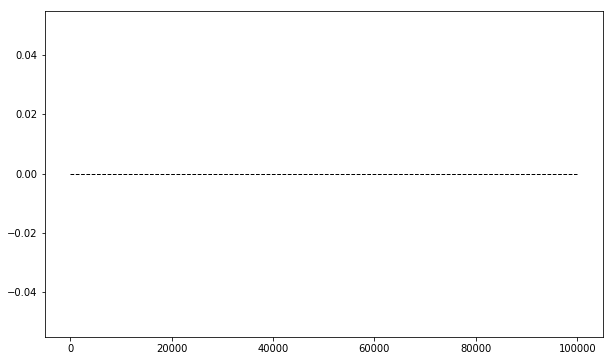

In [31]:
make_coefficient_plot(table, positive_words, negative_words, l2_penalty_list=[0, 4, 10, 1e2, 1e3, 1e5])

**Quiz Question**: (True/False) All coefficients consistently get smaller in size as the L2 penalty is increased.

**Quiz Question**: (True/False) The relative order of coefficients is preserved as the L2 penalty is increased. (For example, if the coefficient for 'cat' was more positive than that for 'dog', this remains true as the L2 penalty increases.)

## Measuring accuracy

Now, let us compute the accuracy of the classifier model. Recall that the accuracy is given by

$$
\mbox{accuracy} = \frac{\mbox{# correctly classified data points}}{\mbox{# total data points}}
$$


Recall from lecture that that the class prediction is calculated using
$$
\hat{y}_i = 
\left\{
\begin{array}{ll}
      +1 & h(\mathbf{x}_i)^T\mathbf{w} > 0 \\
      -1 & h(\mathbf{x}_i)^T\mathbf{w} \leq 0 \\
\end{array} 
\right.
$$

**Note**: It is important to know that the model prediction code doesn't change even with the addition of an L2 penalty. The only thing that changes is the estimated coefficients used in this prediction.

Based on the above, we will use the same code that was used in Module 3 assignment.

In [37]:
pred_0 = np.dot(feature_matrix_train, coefficients_0_penalty)
print(pred_0)

pred_4 = np.dot(feature_matrix_train, coefficients_4_penalty)
print(pred_4)

[1.11319896 0.94731354 0.51620492 ... 1.60519964 0.86336172 1.53394106]
[1.3500506  1.09607444 0.46707793 ... 2.11078401 1.12340797 1.87032574]


In [39]:
#here range is chaecked for predictions  i.e set range if x:1 x>1 else -1

def get_classification_accuracy1(feature_matrix, sentiment, coefficients):
    scores = np.dot(feature_matrix, coefficients)
    apply_threshold = np.vectorize(lambda x: 1. if x > 1  else -1.)
    predictions = apply_threshold(scores)
    
    num_correct = (predictions == sentiment).sum()
    accuracy = num_correct / len(feature_matrix)    
    return accuracy

Below, we compare the accuracy on the **training data** and **validation data** for all the models that were trained in this assignment.  We first calculate the accuracy values and then build a simple report summarizing the performance for the various models.

In [43]:
# here with accuracy1 total acc is checked with       (x > 1)

train_accuracy1 = {}
train_accuracy1[0]   = get_classification_accuracy1(feature_matrix_train, sentiment_train, coefficients_0_penalty)
train_accuracy1[4]   = get_classification_accuracy1(feature_matrix_train, sentiment_train, coefficients_4_penalty)
train_accuracy1[10]  = get_classification_accuracy1(feature_matrix_train, sentiment_train, coefficients_10_penalty)
train_accuracy1[1e2] = get_classification_accuracy1(feature_matrix_train, sentiment_train, coefficients_1e2_penalty)
train_accuracy1[1e3] = get_classification_accuracy1(feature_matrix_train, sentiment_train, coefficients_1e3_penalty)
train_accuracy1[1e5] = get_classification_accuracy1(feature_matrix_train, sentiment_train, coefficients_1e5_penalty)

validation_accuracy1 = {}
validation_accuracy1[0]   = get_classification_accuracy1(feature_matrix_valid, sentiment_valid, coefficients_0_penalty)
validation_accuracy1[4]   = get_classification_accuracy1(feature_matrix_valid, sentiment_valid, coefficients_4_penalty)
validation_accuracy1[10]  = get_classification_accuracy1(feature_matrix_valid, sentiment_valid, coefficients_10_penalty)
validation_accuracy1[1e2] = get_classification_accuracy1(feature_matrix_valid, sentiment_valid, coefficients_1e2_penalty)
validation_accuracy1[1e3] = get_classification_accuracy1(feature_matrix_valid, sentiment_valid, coefficients_1e3_penalty)
validation_accuracy1[1e5] = get_classification_accuracy1(feature_matrix_valid, sentiment_valid, coefficients_1e5_penalty)

In [45]:
# Build a simple report
for key in sorted(validation_accuracy1.keys()):
    print ("L2 penalty = %g" % key )
    print ("train accuracy1 = %s, validation_accuracy1 = %s" % (train_accuracy1[key], validation_accuracy1[key]) )
    print ("--------------------------------------------------------------------------------" )

L2 penalty = 0
train accuracy1 = 0.64405, validation_accuracy1 = 0.6536
--------------------------------------------------------------------------------
L2 penalty = 4
train accuracy1 = 0.6932, validation_accuracy1 = 0.696
--------------------------------------------------------------------------------
L2 penalty = 10
train accuracy1 = 0.69295, validation_accuracy1 = 0.6958
--------------------------------------------------------------------------------
L2 penalty = 100
train accuracy1 = 0.6879, validation_accuracy1 = 0.6914
--------------------------------------------------------------------------------
L2 penalty = 1000
train accuracy1 = 0.6004, validation_accuracy1 = 0.6146
--------------------------------------------------------------------------------
L2 penalty = 100000
train accuracy1 = 0.563, validation_accuracy1 = 0.5676
--------------------------------------------------------------------------------


In [48]:
def get_classification_accuracy(feature_matrix, sentiment, coefficients):
    scores = np.dot(feature_matrix, coefficients)
    apply_threshold = np.vectorize(lambda x: 1. if x > 0  else -1.)
    predictions = apply_threshold(scores)
    
    num_correct = (predictions == sentiment).sum()
    accuracy = num_correct / len(feature_matrix)    
    return accuracy

In [49]:
train_accuracy = {}
train_accuracy[0]   = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_0_penalty)
train_accuracy[4]   = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_4_penalty)
train_accuracy[10]  = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_10_penalty)
train_accuracy[1e2] = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_1e2_penalty)
train_accuracy[1e3] = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_1e3_penalty)
train_accuracy[1e5] = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_1e5_penalty)

validation_accuracy = {}
validation_accuracy[0]   = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_0_penalty)
validation_accuracy[4]   = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_4_penalty)
validation_accuracy[10]  = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_10_penalty)
validation_accuracy[1e2] = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_1e2_penalty)
validation_accuracy[1e3] = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_1e3_penalty)
validation_accuracy[1e5] = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_1e5_penalty)

In [50]:
# Build a simple report
for key in sorted(validation_accuracy.keys()):
    print ("L2 penalty = %g" % key )
    print ("train accuracy = %s, validation_accuracy = %s" % (train_accuracy[key], validation_accuracy[key]) )
    print ("--------------------------------------------------------------------------------" )

L2 penalty = 0
train accuracy = 0.7492, validation_accuracy = 0.7424
--------------------------------------------------------------------------------
L2 penalty = 4
train accuracy = 0.76825, validation_accuracy = 0.7628
--------------------------------------------------------------------------------
L2 penalty = 10
train accuracy = 0.7675, validation_accuracy = 0.762
--------------------------------------------------------------------------------
L2 penalty = 100
train accuracy = 0.7595, validation_accuracy = 0.7552
--------------------------------------------------------------------------------
L2 penalty = 1000
train accuracy = 0.73525, validation_accuracy = 0.727
--------------------------------------------------------------------------------
L2 penalty = 100000
train accuracy = 0.73435, validation_accuracy = 0.7256
--------------------------------------------------------------------------------


<function matplotlib.pyplot.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)>

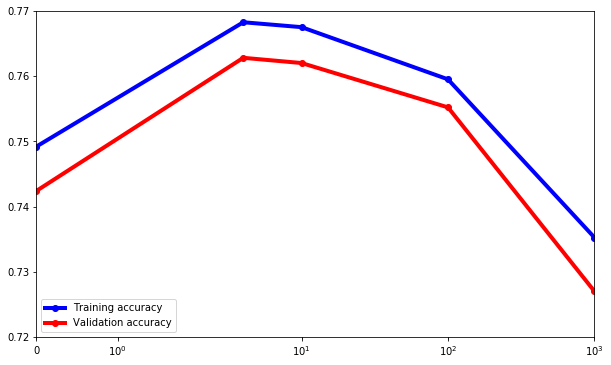

In [52]:
# Optional. Plot accuracy on training and validation sets over choice of L2 penalty.
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 6

sorted_list = sorted(train_accuracy.items(), key=lambda x:x[0])
plt.plot([p[0] for p in sorted_list], [p[1] for p in sorted_list], 'bo-', linewidth=4, label='Training accuracy')
sorted_list = sorted(validation_accuracy.items(), key=lambda x:x[0])
plt.plot([p[0] for p in sorted_list], [p[1] for p in sorted_list], 'ro-', linewidth=4, label='Validation accuracy')
plt.xscale('symlog')
plt.axis([0, 1e3, 0.72, 0.77])
plt.legend(loc='lower left')
plt.rcParams.update({'font.size': 18})
plt.tight_layout

* **Quiz Question**: Which model (L2 = 0, 4, 10, 100, 1e3, 1e5) has the **highest** accuracy on the **training** data?
* **Quiz Question**: Which model (L2 = 0, 4, 10, 100, 1e3, 1e5) has the **highest** accuracy on the **validation** data?
* **Quiz Question**: Does the **highest** accuracy on the **training** data imply that the model is the best one?